In [2]:
############################ Packages
import os
import pandas as pd
import datetime
import numpy as np
import datetime
from matplotlib import pyplot
import seaborn as sns
import sys 
from scipy.stats import randint
 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

import warnings
warnings.filterwarnings("ignore")



In [3]:
orders_initial =pd.read_csv('data\df_merged.csv'  , parse_dates=['date'] )
orders_initial.head()

,date,item_code,quantity,unit_price_vat_excl,site,country_code,brand_name,group0,group1,group2,...,country,temperature,Weather_Condition,sale_amnt,month,year_month,year_week,weekday,yearweek,yearday
0,2019-06-01,ZB00023833,1,22.326744,top4sport,CZ,Under Armour,Apparel,Pants,Shorts,...,Czechia,19.0,Cloudy,22.326744,6,2019-06,2019-21,5,21,152
1,2019-06-01,ZB00000154,1,10.378682,top4running,CZ,Nike,Apparel,T-Shirts,NaN,...,Czechia,19.0,Cloudy,10.378682,6,2019-06,2019-21,5,21,152
2,2019-06-01,ZB00007330,1,14.959302,top4running,CZ,Nike,Apparel,T-Shirts,NaN,...,Czechia,19.0,Cloudy,14.959302,6,2019-06,2019-21,5,21,152
3,2019-06-01,ZB00018948,1,25.594186,top4running,CZ,Nike,Apparel,T-Shirts,Tank,...,Czechia,19.0,Cloudy,25.594186,6,2019-06,2019-21,5,21,152
4,2019-06-01,ZB00022416,1,28.797674,top4running,CZ,Nike,Apparel,Pants,Shorts,...,Czechia,19.0,Cloudy,28.797674,6,2019-06,2019-21,5,21,152


In [4]:
orders = orders_initial[['date','quantity','unit_price_vat_excl','weekday','month','year_month','year_week','yearweek','yearday','brand_name','group0','group1',
                         'category','country','temperature']].sort_values('date')

orders.head()


,date,quantity,unit_price_vat_excl,weekday,month,year_month,year_week,yearweek,yearday,brand_name,group0,group1,category,country,temperature
0,2019-06-01,1,22.326744,5,6,2019-06,2019-21,21,152,Under Armour,Apparel,Pants,fitness,Czechia,19.0
96,2019-06-01,3,26.010465,5,6,2019-06,2019-21,21,152,adidas,Equipment,Balls,football,Czechia,19.0
95,2019-06-01,1,2.405061,5,6,2019-06,2019-21,21,152,- žádný výrobce -,Other,NaN,NaN,Hungary,19.0
94,2019-06-01,2,13.628631,5,6,2019-06,2019-21,21,152,Nike,Apparel,Pants,running,Hungary,19.0
93,2019-06-01,1,2.405061,5,6,2019-06,2019-21,21,152,- žádný výrobce -,Other,NaN,NaN,Hungary,19.0


In [5]:
# Calculate daily Quantities
result = pd.DataFrame(orders.groupby(['date','year_month' ,'yearday' , 'weekday','country' ], as_index=False).agg({ 'temperature':'mean' , 'quantity': 'sum'  }))

######## Select Country
dataset = result[result['country'] == 'Czechia']
dataset = dataset.drop(columns = ['country'])



In [6]:
dataset.head()

,date,year_month,yearday,weekday,temperature,quantity
0,2019-06-01,2019-06,152,5,19.0,99
6,2019-06-02,2019-06,153,6,21.0,5
7,2019-06-03,2019-06,154,0,21.0,42
10,2019-06-04,2019-06,155,1,22.0,1142
15,2019-06-05,2019-06,156,2,22.0,1717


In [7]:
dataset.set_index('date' , inplace=True )
dataset.head()

,year_month,yearday,weekday,temperature,quantity
date,,,,,
2019-06-01,2019-06,152,5,19.0,99
2019-06-02,2019-06,153,6,21.0,5
2019-06-03,2019-06,154,0,21.0,42
2019-06-04,2019-06,155,1,22.0,1142
2019-06-05,2019-06,156,2,22.0,1717


In [8]:
#dataset=dataset[['quantity','temperature']].resample('W').agg(['sum','mean'])
q=pd.DataFrame(dataset.quantity.resample('M').agg('sum'))
t=pd.DataFrame(dataset.temperature.resample('M').agg('mean'))
yw=pd.DataFrame(dataset.yearday.resample('M').agg('mean'))
print(q.head())
print(t.head())
print(yw.head())

            quantity
date                
2019-06-30     13277
2019-07-31     20159
2019-08-31     21727
2019-09-30     18431
2019-10-31     16304
            temperature
date                   
2019-06-30    21.250000
2019-07-31    19.741935
2019-08-31    20.419355
2019-09-30    14.566667
2019-10-31    10.838710
            yearday
date               
2019-06-30   166.75
2019-07-31   197.00
2019-08-31   228.00
2019-09-30   258.50
2019-10-31   289.00


In [9]:
#df_merged = df_orders.merge(df_items, on='item_code', how='left') 
dataset =      yw.merge(t, on='date', how='left') 
dataset = dataset.merge(q, on='date', how='left') 
dataset.head()

,yearday,temperature,quantity
date,,,
2019-06-30,166.75,21.250000,13277
2019-07-31,197.00,19.741935,20159
2019-08-31,228.00,20.419355,21727
2019-09-30,258.50,14.566667,18431
2019-10-31,289.00,10.838710,16304


In [10]:
dataset.reset_index('date' , inplace=True)
dataset.head()

,date,yearday,temperature,quantity
0,2019-06-30,166.75,21.250000,13277
1,2019-07-31,197.00,19.741935,20159
2,2019-08-31,228.00,20.419355,21727
3,2019-09-30,258.50,14.566667,18431
4,2019-10-31,289.00,10.838710,16304


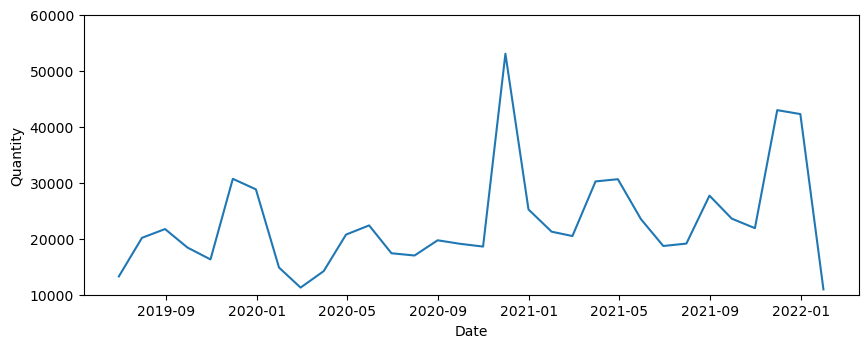

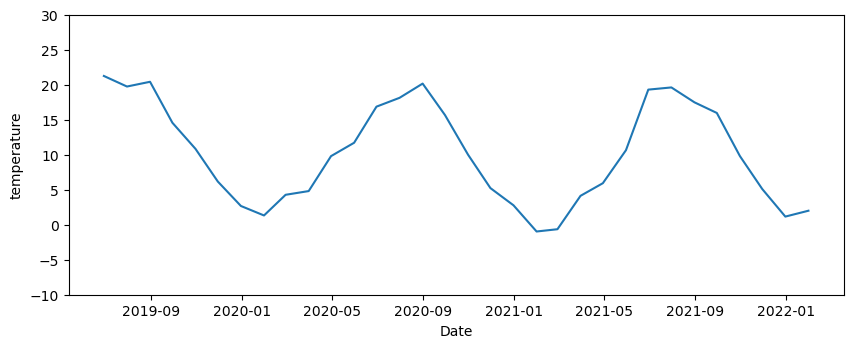

In [11]:
pyplot.figure(figsize=(10,8))
pyplot.subplot(2, 1, 1)
pyplot.plot(dataset['date'],dataset['quantity'])
pyplot.xticks(rotation = 0, size=10)
pyplot.yticks( size=10)
pyplot.xlabel('Date') 
pyplot.ylabel('Quantity') 
pyplot.ylim(10000,60000)
pyplot.show()

pyplot.figure(figsize=(10,8))
pyplot.subplot(2, 1, 2)
pyplot.plot(dataset['date'],dataset['temperature'])
pyplot.xticks(rotation = 0, size=10)
pyplot.yticks( size=10)
pyplot.xlabel('Date') 
pyplot.ylabel('temperature') 
pyplot.ylim(-10,30)
pyplot.show()

In [12]:
problem_description = 'Problem'

# specify the number of lag hours
n_lag = 1
n_lead = 1

In [13]:
############################### LSTM

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [14]:


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
 # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:
dataset.head()

,date,yearday,temperature,quantity
0,2019-06-30,166.75,21.250000,13277
1,2019-07-31,197.00,19.741935,20159
2,2019-08-31,228.00,20.419355,21727
3,2019-09-30,258.50,14.566667,18431
4,2019-10-31,289.00,10.838710,16304


In [16]:
df=dataset.iloc[:,1:]
print(df.shape)
df.head()

(32, 3)


,yearday,temperature,quantity
0,166.75,21.250000,13277
1,197.00,19.741935,20159
2,228.00,20.419355,21727
3,258.50,14.566667,18431
4,289.00,10.838710,16304


In [17]:
# load dataset
values = df.values
# integer encode direction
### encoder = LabelEncoder()
### values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_features = values.shape[1]
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, n_lead+1 )
print(reframed.shape)

reframed.head()

(30, 9)


,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t),var1(t+1),var2(t+1),var3(t+1)
1,0.463610,1.000000,0.055119,0.551674,0.932123,0.218691,0.641921,0.962614,0.255960
2,0.551674,0.932123,0.218691,0.641921,0.962614,0.255960,0.730713,0.699189,0.177620
3,0.641921,0.962614,0.255960,0.730713,0.699189,0.177620,0.819505,0.531398,0.127065
4,0.730713,0.699189,0.177620,0.819505,0.531398,0.127065,0.908297,0.321113,0.469113
5,0.819505,0.531398,0.127065,0.908297,0.321113,0.469113,0.997089,0.164065,0.424381


In [18]:
values.shape[1]

3

In [19]:
# split into train and test sets
values = reframed.values

n_train = int(values.shape[0]*0.8)

train = values[:n_train, :]
test = values[n_train:, :]

# split into input and outputs
n_obs = ( n_lag +1 ) * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X,  test_y  =  test[:, :n_obs],  test[:, -1]
print('train: ', train_X.shape,  train_y.shape)
print('test : ',test_X.shape,  test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag + 1 , n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag + 1, n_features))
print('train: ', train_X.shape, train_y.shape)
print('test : ', test_X.shape, test_y.shape)

train:  (24, 6) (24,)
test :  (6, 6) (6,)
train:  (24, 2, 3) (24,)
test :  (6, 2, 3) (6,)


Epoch 1/100
1/1 - 6s - loss: 0.1066 - val_loss: 0.2195 - 6s/epoch - 6s/step
Epoch 2/100
1/1 - 0s - loss: 0.0983 - val_loss: 0.2058 - 40ms/epoch - 40ms/step
Epoch 3/100
1/1 - 0s - loss: 0.0909 - val_loss: 0.1926 - 42ms/epoch - 42ms/step
Epoch 4/100
1/1 - 0s - loss: 0.0845 - val_loss: 0.1800 - 43ms/epoch - 43ms/step
Epoch 5/100
1/1 - 0s - loss: 0.0787 - val_loss: 0.1680 - 40ms/epoch - 40ms/step
Epoch 6/100
1/1 - 0s - loss: 0.0723 - val_loss: 0.1563 - 40ms/epoch - 40ms/step
Epoch 7/100
1/1 - 0s - loss: 0.0656 - val_loss: 0.1451 - 40ms/epoch - 40ms/step
Epoch 8/100
1/1 - 0s - loss: 0.0613 - val_loss: 0.1345 - 41ms/epoch - 41ms/step
Epoch 9/100
1/1 - 0s - loss: 0.0565 - val_loss: 0.1243 - 42ms/epoch - 42ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0529 - val_loss: 0.1149 - 41ms/epoch - 41ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0494 - val_loss: 0.1062 - 40ms/epoch - 40ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0472 - val_loss: 0.0985 - 44ms/epoch - 44ms/step
Epoch 13/100
1/1 - 0s - loss: 0.0427 - va

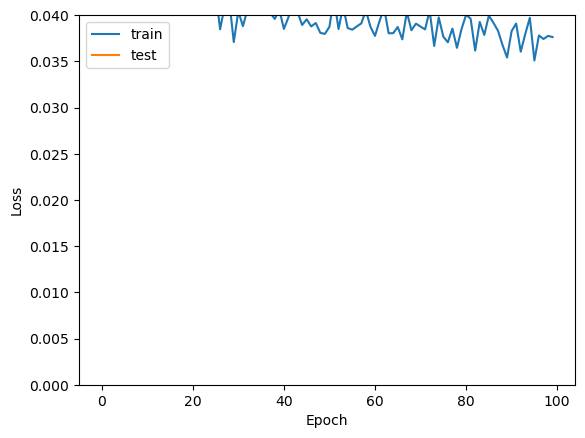

In [20]:
# design network 
model = Sequential()
model.add(LSTM(70, return_sequences=True , input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(70))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
n_epochs=100
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.ylim(0,.04)
pyplot.xlabel('Epoch') 
pyplot.ylabel('Loss') 
pyplot.legend()
pyplot.show()

In [21]:
from numpy import concatenate
from sklearn.metrics import mean_squared_error

In [22]:
# make a prediction
yhat = model.predict(test_X)
print(yhat.shape)


1/1 [==============================] - 1s 956ms/step
(6, 1)


In [23]:
n_row=yhat.shape[0]
n_col=n_features
x = [[None for _ in range(n_col)] for _ in range(n_row)]

for i in range(0,n_row):
    for j in range(0,n_col):
        x[i][j] = yhat[i][0]
x=np.array(x)
print(x.shape)


(6, 3)


In [24]:
inv_yhat = scaler.inverse_transform(x)
inv_yhat
inv_yhat=inv_yhat[:,n_features-1]

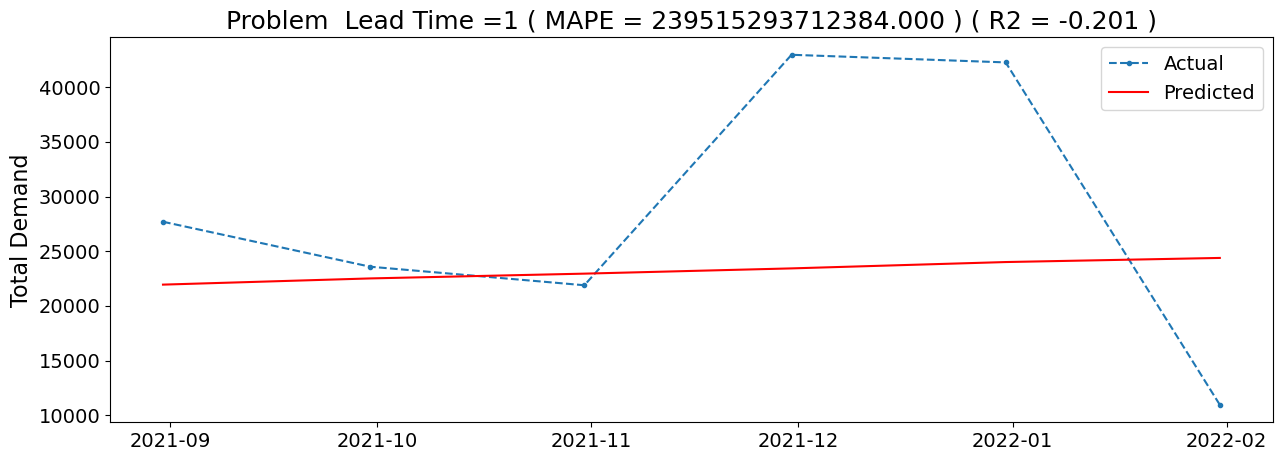

In [25]:

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

graph=dataset.tail(n_row)
graph['predict']  = inv_yhat
true_value=graph['quantity']

mape = mean_absolute_percentage_error(test_y, yhat)
R2=r2_score(test_y, yhat)

pyplot.figure(figsize=(15,5))
pyplot.plot(graph['date'] , graph['quantity'],linestyle='dashed', marker='.', label="Actual" )
pyplot.plot(graph['date'] , graph['predict'], 'r' , label="Predicted" )
pyplot.title(problem_description + '  Lead Time =' + str(n_lead) + ' ( MAPE = ' + ('%.3f' % mape) +' )' + ' ( R2 = ' + ('%.3f' % R2) +' )' , size=18)
#pyplot.xlabel('Time step', size=12)
pyplot.ylabel('Total Demand', size=16)
pyplot.legend(fontsize=14)
pyplot.xticks(fontsize=14)
pyplot.yticks(fontsize=14)
pyplot.show()